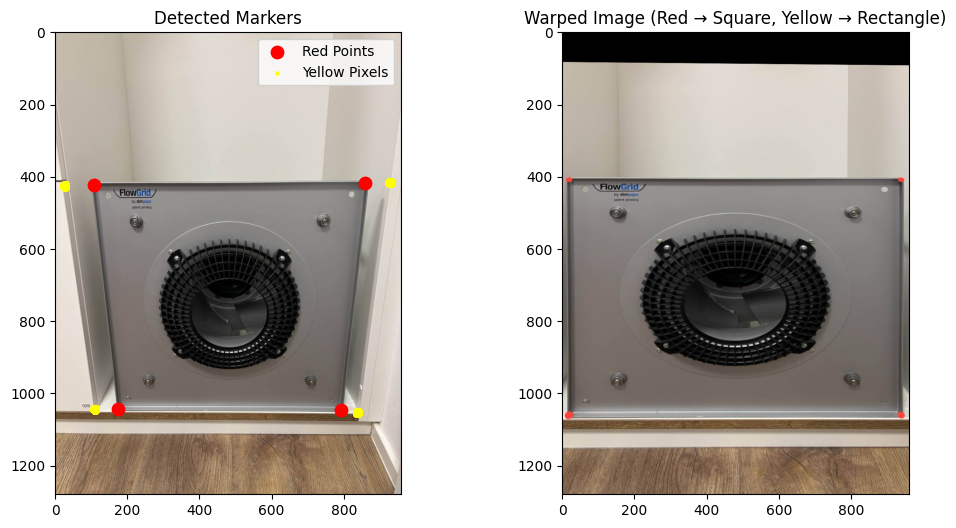

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# --- Load image from local path ---
image_path ='red_yellow_dots_ruler.jpg'.strip()
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found: {image_path}")

# --- Read image ---
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Failed to read the image. Check file path or format.")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# --- Robust red detection in HSV ---
# Combine two hue ranges (for red hue wrapping around 0)
lower_red1 = np.array([0, 120, 70])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([160, 120, 70])
upper_red2 = np.array([179, 255, 255])

mask_red = cv2.inRange(hsv, lower_red1, upper_red1) | cv2.inRange(hsv, lower_red2, upper_red2)

# Remove small noise and fill small holes
mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

# --- Find contours (red blobs) ---
contours, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) < 4:
    raise ValueError(f"Expected at least 4 red blobs, found {len(contours)}. Try using larger red markers.")

# Sort by area (largest first) and take 4
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:4]

# Compute centers of these 4 red blobs
red_points = []
for c in contours:
    M = cv2.moments(c)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        red_points.append((cx, cy))
red_points = np.array(red_points, dtype=np.float32)

if len(red_points) != 4:
    raise ValueError(f"Detected {len(red_points)} valid red centers. Try adjusting red marker color or size.")

# Sort red points (top-left → bottom-right)
red_sorted = sorted(red_points, key=lambda p: (p[1], p[0]))
top = sorted(red_sorted[:2], key=lambda p: p[0])
bottom = sorted(red_sorted[2:], key=lambda p: p[0])
pts_src = np.array([top[0], top[1], bottom[1], bottom[0]], dtype=np.float32)

# --- Detect yellow area robustly ---
lower_yellow = np.array([20, 80, 100])
upper_yellow = np.array([35, 255, 255])
mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))

yellow_points = np.argwhere(mask_yellow > 0)
if len(yellow_points) < 4:
    raise ValueError(f"Expected at least 4 yellow edge points, found {len(yellow_points)}.")

y_min, x_min = yellow_points.min(axis=0)
y_max, x_max = yellow_points.max(axis=0)
pts_dst = np.array([
    [x_min, y_min],
    [x_max, y_min],
    [x_max, y_max],
    [x_min, y_max]
], dtype=np.float32)

# --- Warp image ---
H, _ = cv2.findHomography(pts_src, pts_dst)
warped = cv2.warpPerspective(image_rgb, H, (image.shape[1], image.shape[0]))

# --- Visualization ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.scatter(red_points[:, 0], red_points[:, 1], c='red', s=80, label='Red Points')
plt.scatter([p[1] for p in yellow_points], [p[0] for p in yellow_points], c='yellow', s=5, label='Yellow Pixels')
plt.title("Detected Markers")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(warped)
plt.title("Warped Image (Red → Square, Yellow → Rectangle)")
plt.show()


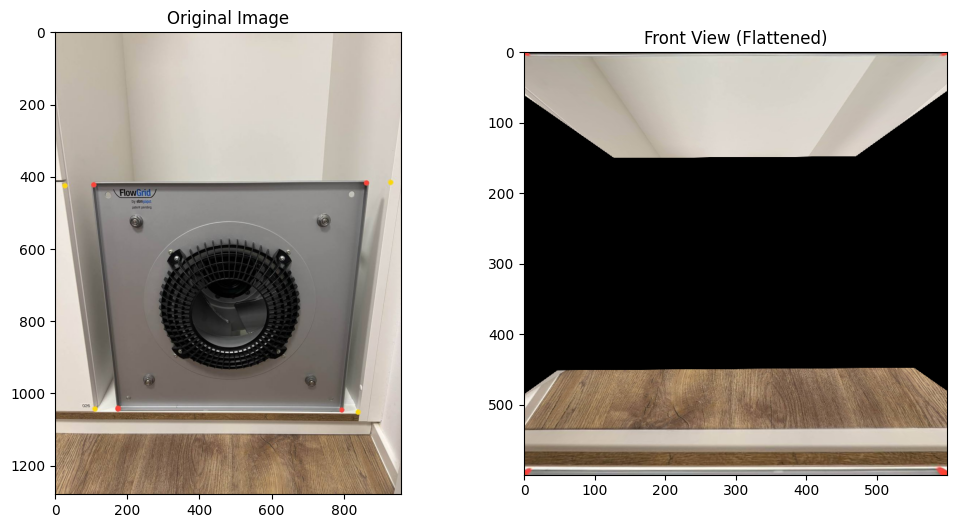

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Load image ---
image = cv2.imread("red_yellow_dots_ruler.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# --- Define red color range in BGR ---
lower_red = np.array([0, 0, 120])      # more tolerant range for red detection
upper_red = np.array([80, 80, 255])

mask_red = cv2.inRange(image, lower_red, upper_red)

# --- Find contours of red dots ---
contours, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
points = []
for c in contours:
    M = cv2.moments(c)
    if M["m00"] > 0:
        cx = int(M["m10"]/M["m00"])
        cy = int(M["m01"]/M["m00"])
        points.append((cx, cy))

if len(points) != 4:
    raise ValueError(f"Expected 4 red points, but found {len(points)}. Check thresholds or marker visibility.")

# --- Sort points: top-left, top-right, bottom-right, bottom-left ---
points = sorted(points, key=lambda p: (p[1], p[0]))  # sort by y first
top_points = sorted(points[:2], key=lambda p: p[0])
bottom_points = sorted(points[2:], key=lambda p: p[0])
ordered_pts = np.array(top_points + bottom_points, dtype="float32")

# --- Define output (flattened) rectangle ---
width = 600
height = 600
target_pts = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]
], dtype="float32")

# --- Compute perspective transform ---
matrix = cv2.getPerspectiveTransform(ordered_pts, target_pts)
warped = cv2.warpPerspective(image_rgb, matrix, (width, height))

# --- Show results ---
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(warped)
plt.title("Front View (Flattened)")
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# --- Load image from local path ---
image_path ='red_yellow_dots_ruler.jpg'.strip()
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# --- Find red pixels (assumes you marked exactly 4 corners in red) ---
#mask = (image[:, :, 2] > 200) & (image[:, :, 1] < 50) & (image[:, :, 0] < 50)
#mask = (image[:, :, 0] == 255) & (image[:, :, 1] == 0) & (image[:, :, 2] == 0)
mask = (image[:, :, 0] == 0) & (image[:, :, 1] == 0) & (image[:, :, 2] == 255)
points = np.argwhere(mask)
# gives (y, x)
if len(points) != 4:
  raise ValueError(f"Expected 4 red points, found {len(points)}")
# Sort points roughly in top-left, top-right, bottom-right, bottom-left order
# We'll sort by y first (top vs bottom), then x
points = sorted(points, key=lambda p: (p[0], p[1]))
top = sorted(points[:2], key=lambda p: p[1])
# top-left, top-right
bottom = sorted(points[2:], key=lambda p: p[1])
# bottom-left, bottom-right
pts_src = np.array([top[0][::-1], top[1][::-1], bottom[1][::-1], bottom[0][::-1]], dtype=np.float32)
# [::-1] converts (y, x) → (x, y) for OpenCV
# --- Define destination points (perfect square, 10x10 cm scaled arbitrarily to pixels) ---
size_px = 500 # output square image in pixels
pts_dst = np.array([ [0, 0], [size_px, 0], [size_px, size_px], [0, size_px] ], dtype=np.float32)
# --- Compute homography and warp image ---
H, _ = cv2.findHomography(pts_src, pts_dst)
# Estimate the bounding box of the warped image
height, width = image_rgb.shape[:2]
corners = np.array([[0,0], [width,0], [width,height], [0,height]], dtype=np.float32).reshape(-1,1,2)
warped_corners = cv2.perspectiveTransform(corners, H)
x_coords = warped_corners[:,0,0]
y_coords = warped_corners[:,0,1]

min_x, max_x = int(np.floor(x_coords.min())), int(np.ceil(x_coords.max()))
min_y, max_y = int(np.floor(y_coords.min())), int(np.ceil(y_coords.max()))

# Compute new canvas size
canvas_width = max_x - min_x
canvas_height = max_y - min_y

# Adjust homography to shift image into positive coordinates
translation_matrix = np.array([[1, 0, -min_x],
                               [0, 1, -min_y],
                               [0, 0, 1]], dtype=np.float32)
H_translated = translation_matrix @ H

# Create white canvas and warp image onto it
white_canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255
warped = cv2.warpPerspective(image_rgb, H_translated, (canvas_width, canvas_height), dst=white_canvas, borderMode=cv2.BORDER_TRANSPARENT)
# --- Show original and warped images ---
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.scatter([p[1] for p in points], [p[0] for p in points], c='red', s=80, label='Marked Points')
plt.title("Original Image with Red Points")
plt.legend()
plt.subplot(1,2,2)
plt.imshow(warped)
plt.title("Warped Image (Perfect Square)")
plt.show()
# --- Save warped image as a new file ---
cv2.imwrite("new11wrapped.png", cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))

# --- Trigger download ---
files.download("new11wrapped.png")

ValueError: Expected 4 red points, found 0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import files

# --- Upload photo ---
uploaded = files.upload()
image_filename = list(uploaded.keys())[0]
# --- Read image ---
image = cv2.imread(image_filename)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# --- Find red pixels (assumes you marked exactly 4 corners in red) ---
#mask = (image[:, :, 2] > 200) & (image[:, :, 1] < 50) & (image[:, :, 0] < 50)
#mask = (image[:, :, 0] == 255) & (image[:, :, 1] == 0) & (image[:, :, 2] == 0)
mask = (image[:, :, 0] == 0) & (image[:, :, 1] == 0) & (image[:, :, 2] == 255)
points = np.argwhere(mask)
# gives (y, x)
if len(points) != 4:
  raise ValueError(f"Expected 4 red points, found {len(points)}")
# Sort points roughly in top-left, top-right, bottom-right, bottom-left order
# We'll sort by y first (top vs bottom), then x
points = sorted(points, key=lambda p: (p[0], p[1]))
top = sorted(points[:2], key=lambda p: p[1])
# top-left, top-right
bottom = sorted(points[2:], key=lambda p: p[1])
# bottom-left, bottom-right
pts_src = np.array([top[0][::-1], top[1][::-1], bottom[1][::-1], bottom[0][::-1]], dtype=np.float32)
# [::-1] converts (y, x) → (x, y) for OpenCV
# --- Define destination points (perfect square, 10x10 cm scaled arbitrarily to pixels) ---
size_px = 500 # output square image in pixels
pts_dst = np.array([ [0, 0], [size_px, 0], [size_px, size_px], [0, size_px] ], dtype=np.float32)
# --- Compute homography and warp image ---
H, _ = cv2.findHomography(pts_src, pts_dst)
# Estimate the bounding box of the warped image
height, width = image_rgb.shape[:2]
corners = np.array([[0,0], [width,0], [width,height], [0,height]], dtype=np.float32).reshape(-1,1,2)
warped_corners = cv2.perspectiveTransform(corners, H)
x_coords = warped_corners[:,0,0]
y_coords = warped_corners[:,0,1]

min_x, max_x = int(np.floor(x_coords.min())), int(np.ceil(x_coords.max()))
min_y, max_y = int(np.floor(y_coords.min())), int(np.ceil(y_coords.max()))

# Compute new canvas size
canvas_width = max_x - min_x
canvas_height = max_y - min_y

# Adjust homography to shift image into positive coordinates
translation_matrix = np.array([[1, 0, -min_x],
                               [0, 1, -min_y],
                               [0, 0, 1]], dtype=np.float32)
H_translated = translation_matrix @ H

# Create white canvas and warp image onto it
white_canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255
warped = cv2.warpPerspective(image_rgb, H_translated, (canvas_width, canvas_height), dst=white_canvas, borderMode=cv2.BORDER_TRANSPARENT)
# --- Show original and warped images ---
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.scatter([p[1] for p in points], [p[0] for p in points], c='red', s=80, label='Marked Points')
plt.title("Original Image with Red Points")
plt.legend()
plt.subplot(1,2,2)
plt.imshow(warped)
plt.title("Warped Image (Perfect Square)")
plt.show()
# --- Save warped image as a new file ---
cv2.imwrite("new11wrapped.png", cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))

# --- Trigger download ---
# files.download("new11wrapped.png")

In [15]:
import numpy as np
import cv2

def rewarpping_image(image, output_site_px=500):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    # --- Find red pixels (assumes you marked exactly 4 corners in red) --- 
    mask = (image[:, :, 0] == 0) & (image[:, :, 1] == 0) & (image[:, :, 2] == 255) 
    points = np.argwhere(mask) 
    # gives (y, x) 
    if len(points) != 4: 
        raise ValueError(f"Expected 4 red points, found {len(points)}") 
    # Sort points roughly in top-left, top-right, bottom-right, bottom-left order 
    # We'll sort by y first (top vs bottom), then x 
    points = sorted(points, key=lambda p: (p[0], p[1])) 
    top = sorted(points[:2], key=lambda p: p[1]) 
    # top-left, top-right 
    bottom = sorted(points[2:], key=lambda p: p[1]) 
    # bottom-left, bottom-right 
    pts_src = np.array([top[0][::-1], top[1][::-1], bottom[1][::-1], bottom[0][::-1]], dtype=np.float32) 
    # [::-1] converts (y, x) → (x, y) for OpenCV 
    # --- Define destination points (perfect square, 10x10 cm scaled arbitrarily to pixels) ---     
    pts_dst = np.array([ [0, 0], [output_site_px, 0], [output_site_px, output_site_px], [0, output_site_px] ], dtype=np.float32) 
    # --- Compute homography and warp image ---
    H, _ = cv2.findHomography(pts_src, pts_dst) 
    # Estimate the bounding box of the warped image
    height, width = image_rgb.shape[:2]
    corners = np.array([[0,0], [width,0], [width,height], [0,height]], dtype=np.float32).reshape(-1,1,2)
    warped_corners = cv2.perspectiveTransform(corners, H)
    x_coords = warped_corners[:,0,0]
    y_coords = warped_corners[:,0,1]

    min_x, max_x = int(np.floor(x_coords.min())), int(np.ceil(x_coords.max()))
    min_y, max_y = int(np.floor(y_coords.min())), int(np.ceil(y_coords.max()))

    # Compute new canvas size
    canvas_width = max_x - min_x
    canvas_height = max_y - min_y

    # Adjust homography to shift image into positive coordinates
    translation_matrix = np.array([[1, 0, -min_x],
                                [0, 1, -min_y],
                                [0, 0, 1]], dtype=np.float32)
    H_translated = translation_matrix @ H

    # Create white canvas and warp image onto it
    white_canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255
    warped = cv2.warpPerspective(image_rgb, H_translated, (canvas_width, canvas_height), dst=white_canvas, borderMode=cv2.BORDER_TRANSPARENT)
    
    return warped

image_path ='red_yellow_dots_ruler.jpg'.strip()
image = cv2.imread(image_path)
rewarpping_image(image, output_site_px=500)

ValueError: Expected 4 red points, found 0